In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices("GPU") # Check if GPU is available.

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import os
import cv2
import numpy as np

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import Activation, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

import matplotlib.pyplot as plt


In [4]:
# Set paths to images (for training and testing)
ROOT_DIR = './data/images'
TRAIN_DIR = os.path.join(ROOT_DIR, 'train')
TEST_DIR = os.path.join(ROOT_DIR, 'test')
input_shape = (32, 32, 1) # image shape

# training parameters
batch_size = 128
epochs = 100

In [5]:
# Load data
def load_img(img_path):
    """
    Load images,change resolution of input images, extend the shape of the array of input images.
    :param: img_path: Path of the input image.

    :return: img.astype(np.float32): Output images in data type float32
    """
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # Fit to input size
    img = cv2.resize(img, (32, 32))
    img = np.expand_dims(img, axis=-1)
    return img.astype(np.float32)

In [6]:
def one_hot_encode(labels):
    """
    Converts a class vector (integers) into a binary class matrix.
    :param: labels: classes of images

    :return: target: binary class matrix
    """
    mapper = {'blank': 0, 'nough': 1, 'circle': 2}
    encoded = [mapper[label] for label in labels]
    target = to_categorical(encoded)
    return target

In [7]:
def load_data(root_dir, shuffle=True):
    """
    Loads images with their classes (folder name of the images),
    defines a NumPy array of binary image data and 
    a NumPy array of classes of binary images.
    :param: root_dir: Root directory where the folders of images are created.

    :return: np.asarray(X): Numpy array of binary image data.
             np.asarray(y): Numpy array of classes of binary images
    """
    X, y = [], []
    for root, dirs, files in os.walk(root_dir):
        for class_dir in dirs:
            image_dir = os.path.join(root_dir, class_dir)
            y.extend(np.tile(class_dir, len(os.listdir(image_dir))))
            for img_fn in os.listdir(image_dir):
                img = load_img(os.path.join(image_dir, img_fn))
                X.append(img)
    y = one_hot_encode(y)
    if shuffle:
        # Combine to maintain order
        data = list(zip(X, y))
        np.random.shuffle(data)
        X, y = zip(*data)
    return np.asarray(X), np.asarray(y)

In [8]:
print('Loading data...')
X_train, y_train = load_data(TRAIN_DIR)
X_test, y_test = load_data(TEST_DIR)
print('{} instances for training'.format(len(X_train))) # whole images for training
print('{} instances for evaluation'.format(len(X_test))) # whole images for test

Loading data...
1560 instances for training
120 instances for evaluation


In [9]:
"""
Definition of own CNN to train the model 
"""

# number of classes
K = 3
 
# calculate total number of classes
# for output layer
print("number of classes:", K)
 
# Build the model using the functional API
# input layer
model = Sequential()

# Extracting 64 different features on images (shape = (32,32,1)) with the kernel (3x3)
model.add(Conv2D(64, (3, 3), input_shape=input_shape, padding='same'))
model.add(Activation('relu')) # Activation function RELU

"""
MaxPooling2D Reduces the sampling of the input along its spatial dimensions 
(height and width) by taking, for each channel of the input, the maximum 
value across an input window  (with the size specified by pool_size) is taken.
"""
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Reduces the input

# Dense specifies the shape of the next layer with 64 neurons. 
# (At the end Dense must specify the number of classes in the case 3)
model.add(Dense(64))
model.add(Activation('relu'))

"""
Dropout can be implemented by randomly selecting nodes 
to drop with a certain probability (40% or 0.4) in each weighting update cycle.
"""
model.add(Dropout(0.4))

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(K, activation='softmax'))
model.summary()

number of classes: 3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        640       
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 activation_1 (Activation)   (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                               

In [10]:
##### Specification of the optimisation for compiling
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
print('Training model...')
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size)

Training model...
Epoch 1/100
13/13 [==============================] - 3s 42ms/step - loss: 4.0112 - accuracy: 0.6968 - val_loss: 1.3690e-04 - val_accuracy: 1.0000
Epoch 2/100
13/13 [==============================] - 0s 11ms/step - loss: 0.5549 - accuracy: 0.7962 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 3/100
13/13 [==============================] - 0s 11ms/step - loss: 0.3714 - accuracy: 0.8340 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 4/100
13/13 [==============================] - 0s 11ms/step - loss: 0.2928 - accuracy: 0.8660 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 5/100
13/13 [==============================] - 0s 11ms/step - loss: 0.2639 - accuracy: 0.8801 - val_loss: 2.7514e-04 - val_accuracy: 1.0000
Epoch 6/100
13/13 [==============================] - 0s 11ms/step - loss: 0.2504 - accuracy: 0.8846 - val_loss: 2.5715e-04 - val_accuracy: 1.0000
Epoch 7/100
13/13 [==============================] - 0s 11ms/step - loss: 0.2115 - accuracy: 0.9077 - val_loss: 1.7074

Epoch 57/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0043 - accuracy: 0.9981 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 58/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0060 - accuracy: 0.9987 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 59/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0063 - accuracy: 0.9974 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 60/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0077 - accuracy: 0.9974 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 61/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0062 - accuracy: 0.9974 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 62/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0079 - accuracy: 0.9968 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 63/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0109 - accuracy: 0.9962 - val_loss: 0.000

In [12]:
# Data expansion to increase quantity
data_generator = ImageDataGenerator(
  width_shift_range=0.1, height_shift_range=0.1, 
  rotation_range=90, horizontal_flip=True, 
    vertical_flip=True, rescale=1 / 255)
 
train_generator = data_generator.flow(
    X_train, y_train, batch_size=batch_size)

In [13]:
steps_per_epoch = X_train.shape[0] // batch_size

In [14]:
# Re-training the model with the new data set
r = model.fit(train_generator, validation_data=(X_test, y_test),
              steps_per_epoch=steps_per_epoch, epochs=epochs)

Epoch 1/100
12/12 [==============================] - 1s 41ms/step - loss: 1.0113 - accuracy: 0.5573 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/100
12/12 [==============================] - 0s 32ms/step - loss: 0.7923 - accuracy: 0.7500 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/100
12/12 [==============================] - 0s 33ms/step - loss: 0.5586 - accuracy: 0.8053 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/100
12/12 [==============================] - 0s 33ms/step - loss: 0.3770 - accuracy: 0.8652 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/100
12/12 [==============================] - 0s 32ms/step - loss: 0.3201 - accuracy: 0.8764 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/100
12/12 [==============================] - 0s 33ms/step - loss: 0.2770 - accuracy: 0.8966 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/100
12/12 [==============================] - 0s 33ms/step - loss: 0.2307 - accuracy: 0.9092 - val_loss: 0.0000e+00 -

12/12 [==============================] - 0s 35ms/step - loss: 0.0713 - accuracy: 0.9648 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 58/100
12/12 [==============================] - 0s 33ms/step - loss: 0.0779 - accuracy: 0.9637 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 59/100
12/12 [==============================] - 0s 33ms/step - loss: 0.0737 - accuracy: 0.9693 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 60/100
12/12 [==============================] - 0s 34ms/step - loss: 0.0669 - accuracy: 0.9714 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 61/100
12/12 [==============================] - 0s 36ms/step - loss: 0.0721 - accuracy: 0.9721 - val_loss: 17.2093 - val_accuracy: 0.6667
Epoch 62/100
12/12 [==============================] - 0s 32ms/step - loss: 0.0674 - accuracy: 0.9742 - val_loss: 22.5205 - val_accuracy: 0.6667
Epoch 63/100
12/12 [==============================] - 0s 33ms/step - loss: 0.0662 - accuracy: 0.9721 - val_loss: 33.8449 - val_accuracy: 

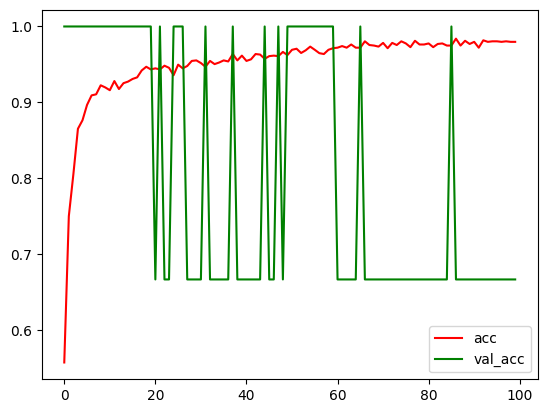

In [15]:
#### Display accuracy per iteration
plt.plot( r.history['accuracy'], label='acc', color='red')
plt.plot(r.history['val_accuracy'], label='val_acc', color='green')
plt.legend()

In [16]:
test_datagen = ImageDataGenerator(rescale=1 / 255)
X_test, y_test = next(test_datagen.flow(X_test, y_test, batch_size=len(X_test)))

loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Crossentropy loss: {:0.3f}'.format(loss))
print('Accuracy: {:0.3f}'.format(acc))

1/1 [==============================] - 0s 24ms/step - loss: 3.9736e-08 - accuracy: 1.0000
Crossentropy loss: 0.000
Accuracy: 1.000


In [17]:
# Save trained model
model.save('./data/model.h5')
print('Saved model to disk')

Saved model to disk
